## Milestone 4:
Milestone 4 continues to add more content to what will become the group's final notebook.  In addition to your refined problem statement and EDA, the new milestone notebook should now include the group's baseline model, pipeline, and interpretation of these initial results.

To complete Milestone 4, students must submit a well organized and markdown-annotated Jupyter notebook with all relevant output visible.
Helper utility .py files used by the notebook are also acceptable.

## Problem statement
The Coffee Quality Institute provides coffee evaluations using tasting experts who score the coffees based on features such as acidity, body, and balance... and one subjective 'overall' scoring, but what contributes to this subjective component?  We set out to determine what features cause a coffee to receive a higher rating, and whether other variables like coffee origin contribute.

**Question : Which features mostly impact our appreciation of the taste of coffee (the general grade given to a coffee) ?**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
from sklearn.decomposition import PCA
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# sklearn imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv('data/merged_data_cleaned.csv')


## Explore and Visualize Data
Conduct exploratory data analysis to understand the underlying patterns and relationships in the data. Visualizations can be helpful in identifying trends and outliers. Make sure that the EDA you present explains the feature engineering choices you made. Moreover, when we read through your notebook, we expect to understand why you choose the particular baseline model and why you engineer your features the way you did. This section would be a great way to provide your reasoning.

In [4]:
g = df.columns.to_series().groupby(df.dtypes).groups
g={k.name: list(v) for k, v in g.items()}

In [5]:
# We noticed that at list one line is a "test" line and does not correspond to coffee samples
df[df["ICO.Number"]=="TEST"]

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
170,170,Arabica,alexandra katona-carroll,Brazil,NaN,NaN,NaN,TEST,NaN,test,...,NaN,0,"March 21st, 2012",NUCOFFEE,567f200bcc17a90070cb952647bf88141ad9c80c,aa2ff513ffb9c844462a1fb07c599bce7f3bb53d,m,NaN,NaN,NaN


### Interaction between columns when we remove outliers

(1339, 12)
(1205, 12)


/Users/alexandraramassamy/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/xy/8nq048wx6dj51dcty_z9_cfr0000gn/T/ipykernel_44201/3133340918.py:14: UserWarning: The figure layout has changed to tight
  a.fig.tight_layout(rect=[0, 0.03, 1, 0.95])


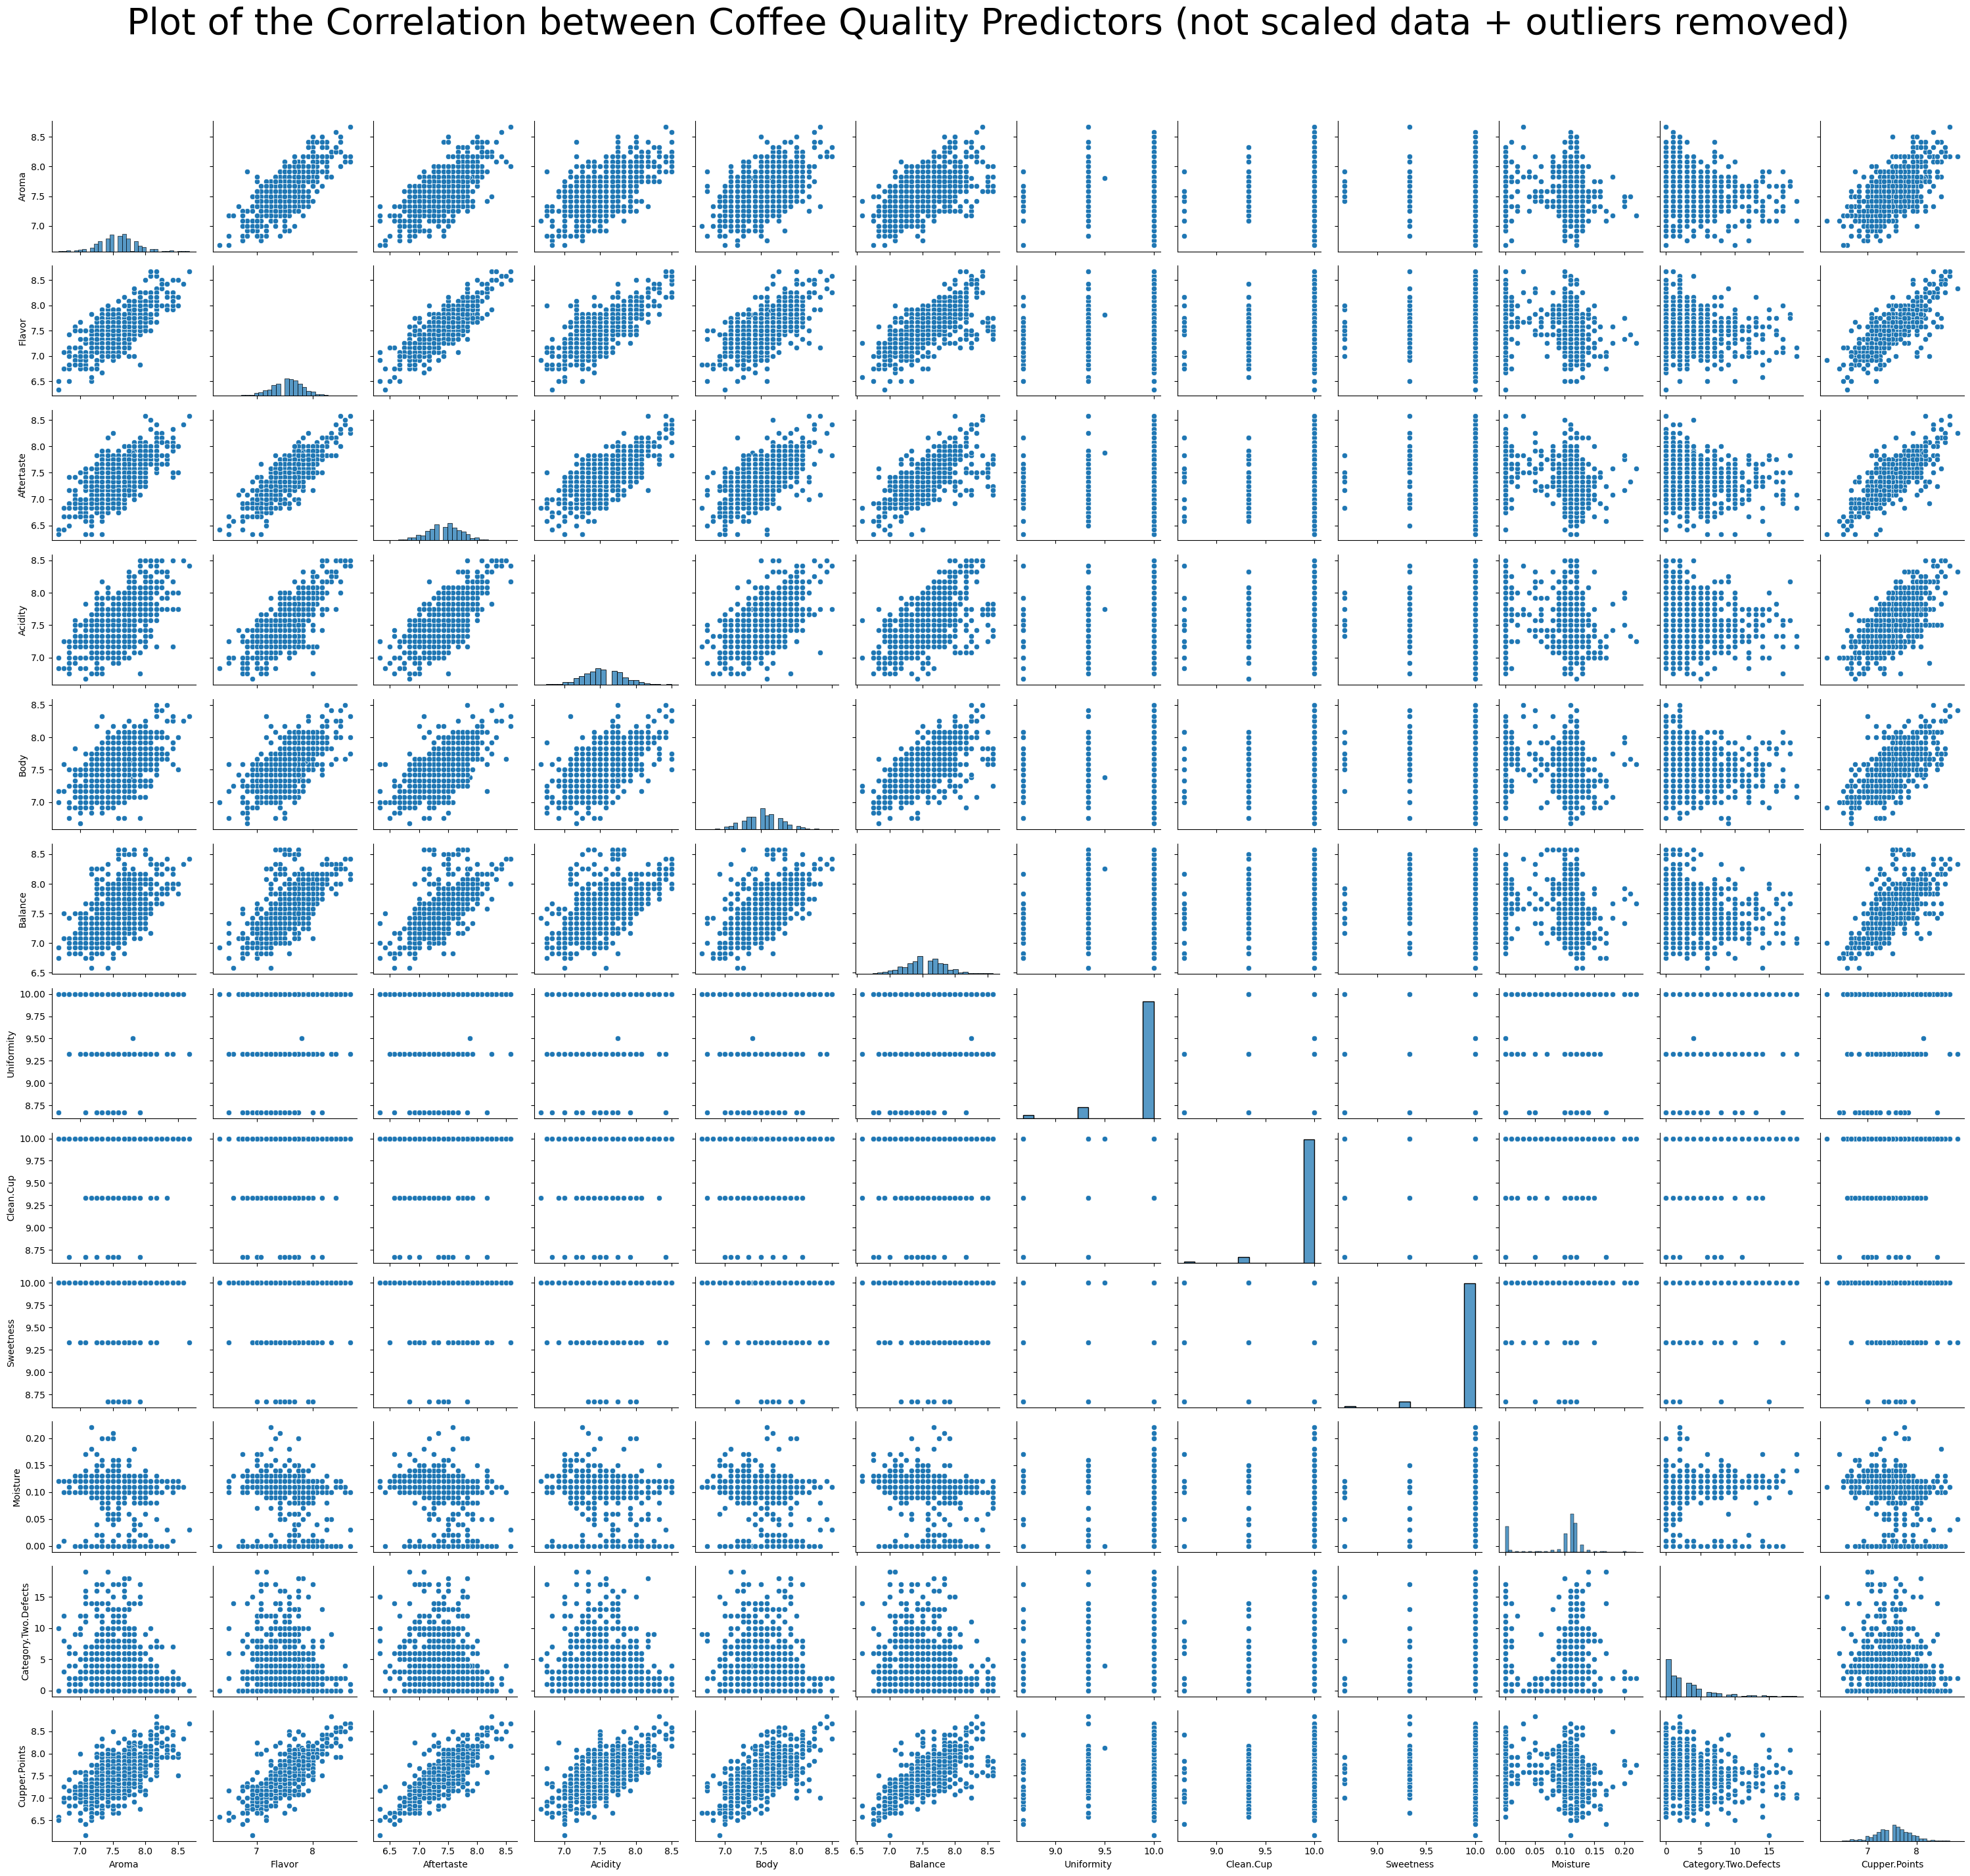

In [6]:
from scipy.stats import zscore

quality_features = ["Aroma","Flavor","Aftertaste","Acidity",
                    "Body","Balance","Uniformity","Clean.Cup",
                    "Sweetness","Moisture","Category.Two.Defects", "Cupper.Points"]
df_quality = df[quality_features]
print(df_quality.shape)

# Removing outliers with Z-score +/- 3
print(df_quality[(np.abs(zscore(df_quality)) < 3).all(axis=1)].shape)

a = sns.pairplot(df_quality[(np.abs(zscore(df_quality)) < 3).all(axis=1)])
a.fig.suptitle("Plot of the Correlation between Coffee Quality Predictors (not scaled data + outliers removed)",fontsize=40)
a.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Many variables seems to be correlated. We notticed that 'Total.Cup.Points' was the some of all the grades. It was the value we initially wanted to predict. However, 'Cupper.Points' is highly correlated to the other grades but is not a function of them but actually reflects a global score given by coffee experts. To generate the previous plot, ~134 outliers were dropped.

### Numerical values exploration

In [7]:
df_num = df[g['int64']+g['float64']]
df_num.shape

(1339, 20)

In [8]:
df_num.describe()

,Unnamed: 0,Number.of.Bags,Category.One.Defects,Category.Two.Defects,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Quakers,altitude_low_meters,altitude_high_meters,altitude_mean_meters
count,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1338.000000,1109.000000,1109.000000,1109.000000
mean,669.000000,154.182972,0.479462,3.556385,7.566706,7.520426,7.401083,7.535706,7.517498,7.518013,9.834877,9.835108,9.856692,7.503376,82.089851,0.088379,0.173393,1750.713315,1799.347775,1775.030545
std,386.680316,129.987162,2.549683,5.312541,0.377560,0.398442,0.404463,0.379827,0.370064,0.408943,0.554591,0.763946,0.616102,0.473464,3.500575,0.048287,0.832121,8669.440545,8668.805771,8668.626080
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,334.500000,14.000000,0.000000,0.000000,7.420000,7.330000,7.250000,7.330000,7.330000,7.330000,10.000000,10.000000,10.000000,7.250000,81.080000,0.090000,0.000000,1100.000000,1100.000000,1100.000000
50%,669.000000,175.000000,0.000000,2.000000,7.580000,7.580000,7.420000,7.580000,7.500000,7.500000,10.000000,10.000000,10.000000,7.500000,82.500000,0.110000,0.000000,1310.640000,1350.000000,1310.640000
75%,1003.500000,275.000000,0.000000,4.000000,7.750000,7.750000,7.580000,7.750000,7.670000,7.750000,10.000000,10.000000,10.000000,7.750000,83.670000,0.120000,0.000000,1600.000000,1650.000000,1600.000000
max,1338.000000,1062.000000,63.000000,55.000000,8.750000,8.830000,8.670000,8.750000,8.580000,8.750000,10.000000,10.000000,10.000000,10.000000,90.580000,0.280000,11.000000,190164.000000,190164.000000,190164.000000


In [9]:
#Number of lines which have at least one missing value.
np.sum(np.max(df_num.isna(), axis=1))

231

In [10]:
df_num.dropna(axis=0, inplace=True)
idx = df_num["Unnamed: 0"]
idx

/var/folders/xy/8nq048wx6dj51dcty_z9_cfr0000gn/T/ipykernel_44201/2826587645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num.dropna(axis=0, inplace=True)


0          0
1          1
2          2
3          3
4          4
        ... 
1331    1331
1332    1332
1333    1333
1335    1335
1336    1336
Name: Unnamed: 0, Length: 1108, dtype: int64

**We scale the data to be able to compare them :**

In [11]:
scaler = StandardScaler().fit(df_num.drop(columns=["Unnamed: 0"]))
x_scaled = pd.DataFrame(scaler.transform(df_num.drop(columns=["Unnamed: 0"])), columns=df_num.drop(columns=["Unnamed: 0"]).columns)

In this plot, the outliers tend to make the data look even more correlated (then we think that the previous pairplot was a more accurate representation:


/Users/alexandraramassamy/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/xy/8nq048wx6dj51dcty_z9_cfr0000gn/T/ipykernel_44201/1146719283.py:5: UserWarning: The figure layout has changed to tight
  a.fig.tight_layout(rect=[0, 0.03, 1, 0.95])


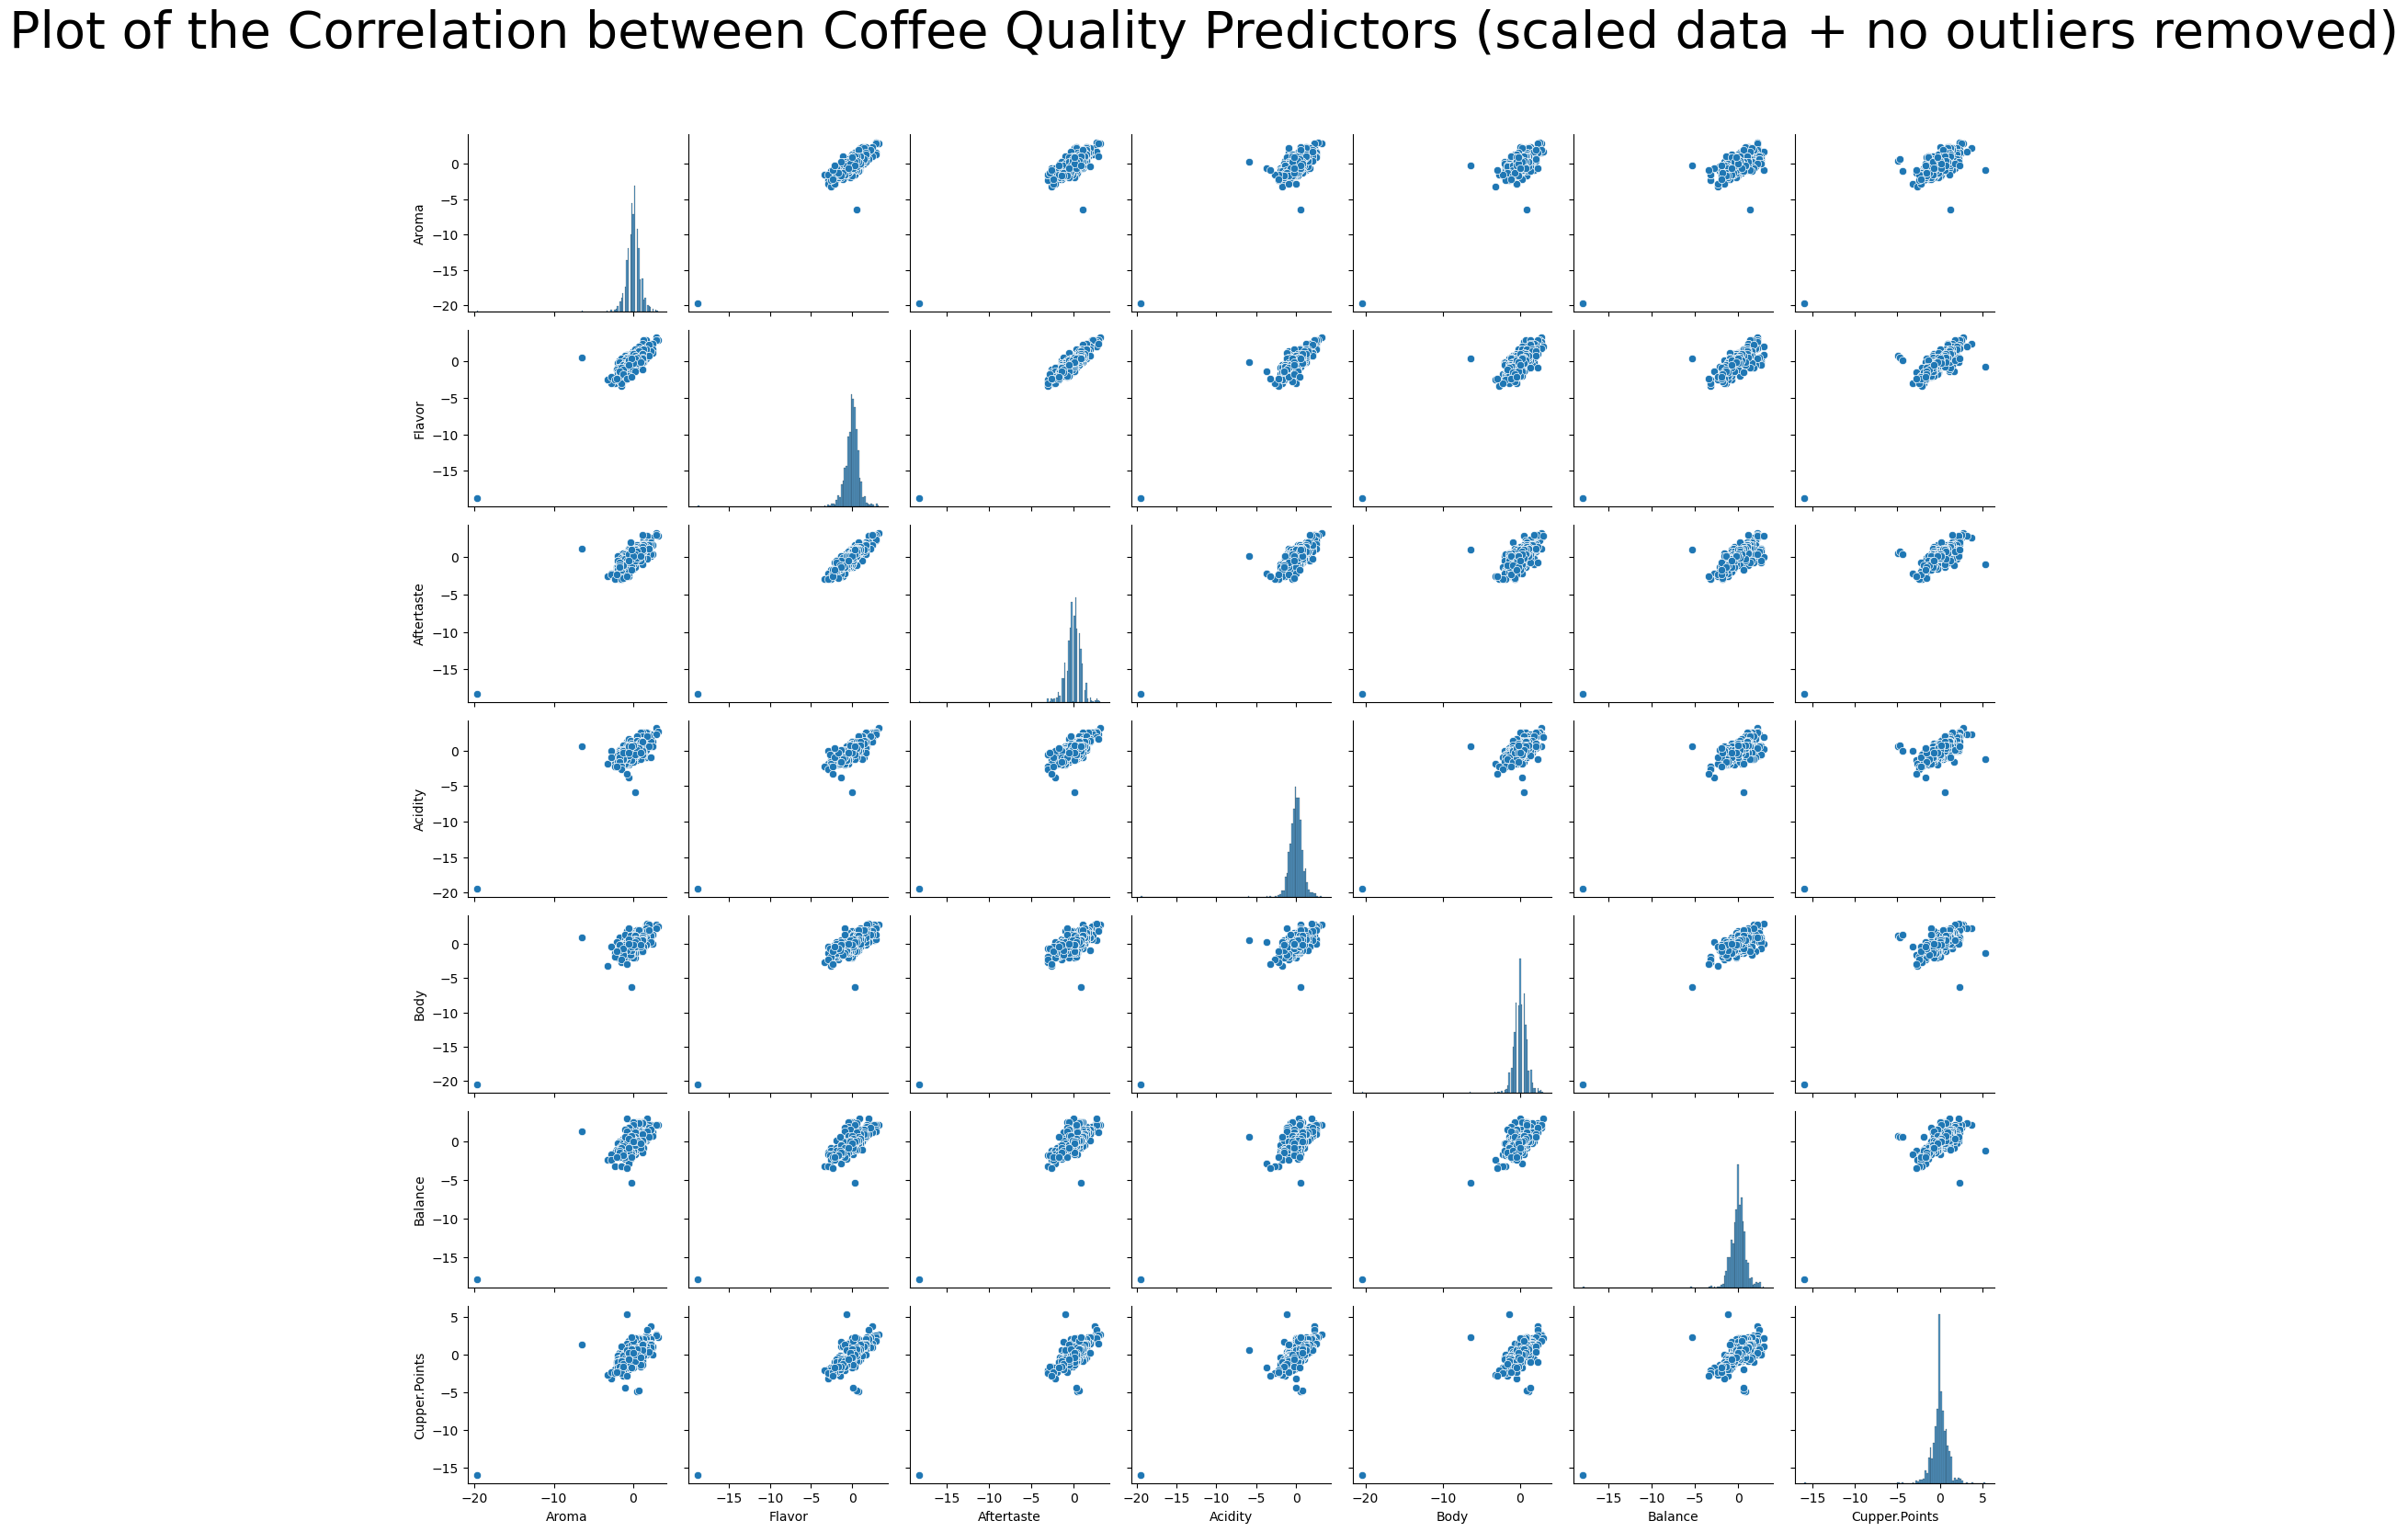

In [12]:
a=sns.pairplot(x_scaled[['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
       'Balance','Cupper.Points']])

a.fig.suptitle("Plot of the Correlation between Coffee Quality Predictors (scaled data + no outliers removed)",fontsize=40)
a.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [13]:
pca = PCA(2).fit(x_scaled )
df_pca = pd.DataFrame(pca.transform(x_scaled ), columns=["pca1", "pca2"])
df_pca

,pca1,pca2
0,-7.506414,0.140361
1,-6.889056,0.128112
2,-6.782711,0.051719
3,-6.046066,0.093117
4,-5.867355,0.115856
...,...,...
1103,0.430334,-0.238463
1104,0.423839,-0.244208
1105,0.995686,0.205980
1106,2.998925,-0.376229


In [14]:
df_plot = df_pca.merge(df["Species"], left_index=True, right_index=True)
df_plot[df_plot["pca2"]>20]

,pca1,pca2,Species
744,1.199741,37.509520,Arabica
870,1.772752,21.492996,Arabica
952,1.852797,37.941320,Arabica


Text(0, 0.5, 'pca2')

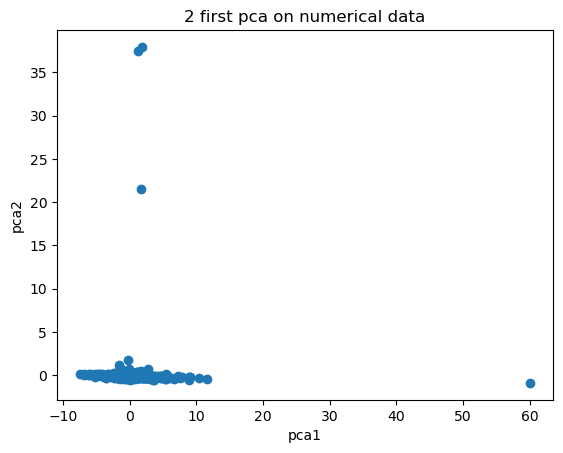

In [15]:
fig, ax = plt.subplots()
ax.scatter(df_plot["pca1"], df_plot["pca2"])
ax.set_title("2 first pca on numerical data")
ax.set_xlabel("pca1")
ax.set_ylabel("pca2")


**We tried to remove the pca outliers lines (`[1082, 744, 870, 952, 868, 949]`) in the original dataset and relaunched the pca then : we still got similar plots where the explaines variance of the second pca component was mostly denerated by a few outliers**

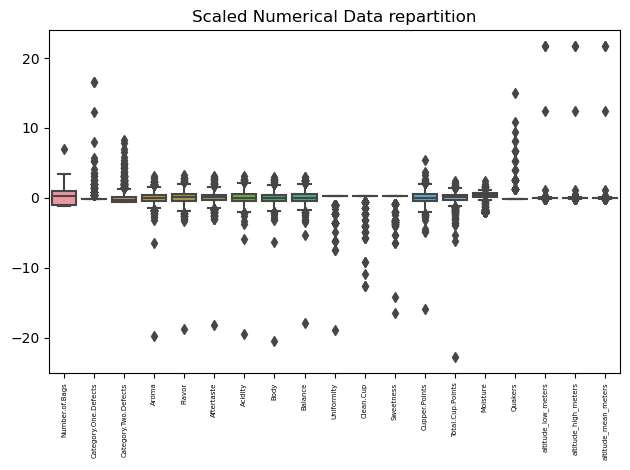

In [16]:

fig, ax = plt.subplots()
sns.boxplot(data=pd.DataFrame(x_scaled, columns=df_num.drop(columns=["Unnamed: 0"]).columns), ax=ax)
plt.xticks(rotation=90, fontsize=5)
ax.set_title("Scaled Numerical Data repartition")
plt.tight_layout()

The previous plot shows that the predictors "Category.One_Defects", "Uniformity", "Sweetness", "Clean.Cup", and "Quakers" have very low variance (mostly just outliers). 

Text(0.5, 1.0, 'Country of origin counts: class imbalances')

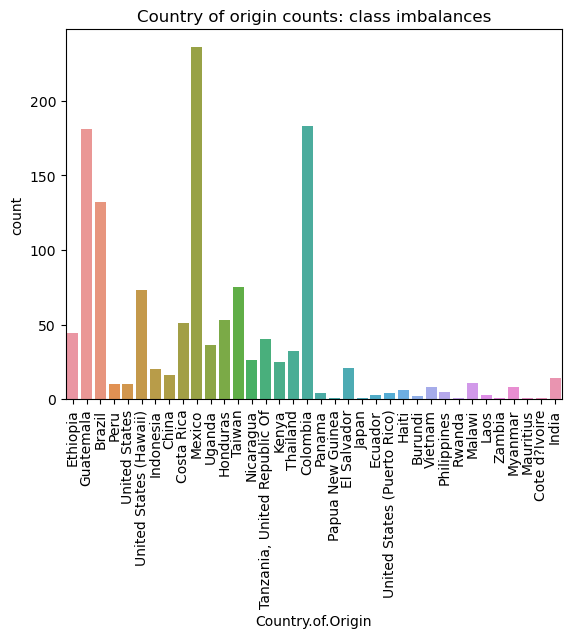

In [17]:
sns.countplot(data=df, x='Country.of.Origin')
plt.xticks(rotation=90)
plt.title("Country of origin counts: class imbalances")


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1339 non-null   int64  
 1   Species                1339 non-null   object 
 2   Owner                  1332 non-null   object 
 3   Country.of.Origin      1338 non-null   object 
 4   Farm.Name              980 non-null    object 
 5   Lot.Number             276 non-null    object 
 6   Mill                   1021 non-null   object 
 7   ICO.Number             1180 non-null   object 
 8   Company                1130 non-null   object 
 9   Altitude               1113 non-null   object 
 10  Region                 1280 non-null   object 
 11  Producer               1107 non-null   object 
 12  Number.of.Bags         1339 non-null   int64  
 13  Bag.Weight             1339 non-null   object 
 14  In.Country.Partner     1339 non-null   object 
 15  Harv

# Data cleaning and preprocessing
- Clean text data
- Feature selection
- Imputation
- Train/test split

In [19]:
df = df.iloc[:,1:]

# drop test datapoint
df = df.drop(df[df['Harvest.Year'] == 'TEST'].index)

print("Dataset shape: ",df.shape)

Dataset shape:  (1338, 43)


In [20]:
df.head(2)

,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


In [21]:
# split into numeric and categorical features
numeric = df.select_dtypes(include=[np.number])
categorical = df.select_dtypes(exclude=[np.number])
print('NUMERIC:')
print(numeric.columns)
print('\nCATEGORICAL:')
print(categorical.columns)

NUMERIC:
Index(['Number.of.Bags', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
       'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points',
       'Total.Cup.Points', 'Moisture', 'Category.One.Defects', 'Quakers',
       'Category.Two.Defects', 'altitude_low_meters', 'altitude_high_meters',
       'altitude_mean_meters'],
      dtype='object')

CATEGORICAL:
Index(['Species', 'Owner', 'Country.of.Origin', 'Farm.Name', 'Lot.Number',
       'Mill', 'ICO.Number', 'Company', 'Altitude', 'Region', 'Producer',
       'Bag.Weight', 'In.Country.Partner', 'Harvest.Year', 'Grading.Date',
       'Owner.1', 'Variety', 'Processing.Method', 'Color', 'Expiration',
       'Certification.Body', 'Certification.Address', 'Certification.Contact',
       'unit_of_measurement'],
      dtype='object')


In [22]:
# PROCESS BAG WEIGHT DATA
print('Unique Bag.Weight values before processing:')
print(categorical['Bag.Weight'].unique())
def fix_bagweight(text):
    vals = text.split()
    bag_weight = int(vals[0])
    # convert to kilograms
    if len(vals) > 1:
        if vals[1] == 'lbs':
            bag_weight *= 0.453592
    return round(bag_weight)

# add bag weight to numeric, drop from categorical
df['Bag.Weight'] = df['Bag.Weight'].apply(fix_bagweight)
categorical = categorical.drop(columns='Bag.Weight')

print('\nUnique Bag.Weight values after processing:')
print(df['Bag.Weight'].unique())

Unique Bag.Weight values before processing:
['60 kg' '1' '30 kg' '69 kg' '1 kg' '2 kg,lbs' '6' '3 lbs' '50 kg' '2 lbs'
 '100 lbs' '15 kg' '2 kg' '2' '70 kg' '19200 kg' '5 lbs' '1 kg,lbs' '6 kg'
 '0 lbs' '46 kg' '40 kg' '20 kg' '34 kg' '1 lbs' '660 kg' '18975 kg'
 '12000 kg' '35 kg' '66 kg' '80 kg' '132 lbs' '5 kg' '25 kg' '59 kg'
 '18000 kg' '150 lbs' '9000 kg' '18 kg' '10 kg' '29 kg' '1218 kg' '4 lbs'
 '0 kg' '13800 kg' '1500 kg' '24 kg' '80 lbs' '8 kg' '3 kg' '350 kg'
 '67 kg' '4 kg' '55 lbs' '100 kg' '130 lbs']

Unique Bag.Weight values after processing:
[   60     1    30    69     2     6    50    45    15    70 19200     0
    46    40    20    34   660 18975 12000    35    66    80     5    25
    59 18000    68  9000    18    10    29  1218 13800  1500    24    36
     8     3   350    67     4   100]


In [23]:
# PROCESS HARVEST YEAR DATA
print('Unique Bag.Weight values before processing:')
print(categorical['Harvest.Year'].unique())
def fix_harvestyear(text):
    text = str(text)
    yr_pattern = re.compile('\d{4}(?=\D|$)')
    match = yr_pattern.search(text)
    if match:
        year = match.group()
        return 2023 - float(year)
    else:
        return np.nan

# add bag weight to numeric, drop from categorical
df['Harvest.Year'] = df['Harvest.Year'].apply(fix_harvestyear)
categorical = categorical.drop(columns='Harvest.Year')

print('\nUnique Harvest.Year values after processing:')
print(df['Harvest.Year'].unique())

Unique Bag.Weight values before processing:
['2014' nan '2013' '2012' 'March 2010' 'Sept 2009 - April 2010'
 'May-August' '2009/2010' '2015' '2011' '2016' '2015/2016' '2010'
 'Fall 2009' '2017' '2009 / 2010' '2010-2011' '2009-2010' '2009 - 2010'
 '2013/2014' '2017 / 2018' 'mmm' 'December 2009-March 2010' '2014/2015'
 '2011/2012' 'January 2011' '4T/10' '2016 / 2017' '23 July 2010'
 'January Through April' '1T/2011' '4t/2010' '4T/2010'
 'August to December' 'Mayo a Julio' '47/2010' 'Abril - Julio' '4t/2011'
 'Abril - Julio /2011' 'Spring 2011 in Colombia.' '3T/2011' '2016/2017'
 '1t/2011' '2018' '4T72010' '08/09 crop']

Unique Harvest.Year values after processing:
[ 9. nan 10. 11. 13. 14.  8. 12.  7.  6.  5.]


In [24]:
# drop outliers
g = df.columns.to_series().groupby(df.dtypes).groups
g={k.name: list(v) for k, v in g.items()}
numerical_vars = df[g['int64']+g['float64']].columns
df_idx = df[numerical_vars]
drop_idx = df_idx[(np.abs(stats.zscore(df_idx)) > 3).any(axis=1)].index
print(len(df))
df = df.drop(drop_idx)

1338


In [25]:
# combine countries with less observations as "Others"
df['Country.of.Origin'] = df['Country.of.Origin'].apply(lambda x: 'Others' if x not in ['Mexico', 'Colombia', 'Guatemala', 'Brazil', 'Taiwan',
       'United States (Hawaii)'] else x)

In [26]:
df['Harvest.Year']

3        9.0
4        9.0
5       10.0
6       11.0
8       13.0
        ... 
1266     9.0
1271     9.0
1272    11.0
1275    11.0
1281    11.0
Name: Harvest.Year, Length: 1184, dtype: float64

In [27]:
# calculate expiration year
df['Expiration_year'] = df['Expiration'].str.extract('(\d{4})')
df['Expiration_year']=df['Expiration_year'].apply(lambda x :  float(x) if x!=None else np.nan)
df['Expiration_year']=df['Expiration_year']+df['Harvest.Year']-2023
df['Expiration_year'].unique()

array([ 2.,  1., nan,  3.,  0.])

In [28]:
predictors = [
    'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
   'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Moisture',
   'Category.One.Defects', 'Quakers', 'Category.Two.Defects',
    'Harvest.Year', 'Bag.Weight', 'Expiration_year', 'Color', 'Country.of.Origin'
]

numeric_cols = [
    'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
   'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Moisture',
   'Category.One.Defects', 'Quakers', 'Category.Two.Defects',
    'Harvest.Year', 'Bag.Weight', 'Expiration_year'
]

categorical_cols = ['Color', 'Country.of.Origin']

In [29]:
# train linear regression on numeric data

train = df[predictors]
y = df['Cupper.Points']



# train-test split
X_train, X_test, y_train, y_test = train_test_split(train, y, 
                                                    test_size = 0.2,
                                                    random_state=0, 
                                                    shuffle=True)

# ohe categorical predicotrs
ohe = OneHotEncoder(drop='first', 
                    sparse=False, 
                    handle_unknown='ignore') 
ohe_train = ohe.fit_transform(X_train[categorical_cols])
# combine numerical and categorical
X_train = pd.merge(
    X_train.drop(columns=categorical_cols).reset_index(drop=True),
    pd.DataFrame(ohe_train, columns=ohe.get_feature_names_out()).reset_index(drop=True),
    left_index=True,
    right_index=True
)

ohe_test = ohe.transform(X_test[categorical_cols])
# combine numerical and categorical
X_test = pd.merge(
    X_test.drop(columns=categorical_cols).reset_index(drop=True),
    pd.DataFrame(ohe_test, columns=ohe.get_feature_names_out()).reset_index(drop=True),
    left_index=True,
    right_index=True
)

# impute missing data
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (947, 25)
y_train shape: (947,)
X_test shape: (237, 25)
y_test shape: (237,)


## Baseline Model
Select an appropriate machine learning model or statistical technique to solve the problem at hand. Train and evaluate the model using appropriate metrics and techniques. This would act as your baseline model, against which you will compare to improve your final model.

In [30]:
# simple Linear Regression Model
lr= LinearRegression().fit(X_train, y_train)
print('Linear regression train score:',lr.score(X_train, y_train))
print('Linear regression test score:', lr.score(X_test, y_test))

Linear regression train score: 0.7542781608142579
Linear regression test score: 0.765411202932506


In [31]:
#unscaled
print('Unscaled LR Coefficients')
name_coef = zip(imputer.get_feature_names_out(),lr.coef_)
for name, coef in sorted(name_coef, key=lambda x:np.abs(x[1]), reverse=True):
    print(f"{name:<25} {round(coef,4)}")

Unscaled LR Coefficients
Flavor                    0.3134
Aftertaste                0.2726
Balance                   0.2273
Acidity                   0.1413
Country.of.Origin_Taiwan  -0.14
Moisture                  -0.122
Body                      0.122
Country.of.Origin_Guatemala -0.0802
Aroma                     0.0509
Country.of.Origin_Colombia -0.049
Country.of.Origin_United States (Hawaii) -0.0409
Clean.Cup                 -0.0365
Sweetness                 0.0362
Color_Green               -0.0199
Color_Bluish-Green        -0.0184
Country.of.Origin_Mexico  -0.0151
Uniformity                0.0096
Harvest.Year              -0.0083
Category.One.Defects      -0.0062
Color_nan                 0.006
Country.of.Origin_Others  -0.0056
Expiration_year           0.0053
Category.Two.Defects      -0.0023
Quakers                   0.0019
Bag.Weight                -0.0001


In [32]:
# simple Linear Regression Model
lr_scaled= LinearRegression().fit(X_train_scaled, y_train)
print('Linear regression train score:',lr_scaled.score(X_train_scaled, y_train))
print('Linear regression test score:', lr_scaled.score(X_test_scaled, y_test))

Linear regression train score: 0.7542781608142579
Linear regression test score: 0.765411202932507


In [33]:
print('Scaled LR Coefficients')
name_coef = zip(imputer.get_feature_names_out(),lr_scaled.coef_)
for name, coef in sorted(name_coef, key=lambda x:np.abs(x[1]), reverse=True):
    print(f"{name:<25} {round(coef,4)}")

Scaled LR Coefficients
Flavor                    0.0954
Aftertaste                0.0845
Balance                   0.072
Acidity                   0.0412
Body                      0.0327
Country.of.Origin_Taiwan  -0.0319
Country.of.Origin_Guatemala -0.0284
Country.of.Origin_Colombia -0.0179
Harvest.Year              -0.0148
Aroma                     0.0147
Color_Green               -0.0095
Country.of.Origin_United States (Hawaii) -0.0089
Category.Two.Defects      -0.0081
Clean.Cup                 -0.0067
Sweetness                 0.0065
Moisture                  -0.0059
Country.of.Origin_Mexico  -0.0056
Color_Bluish-Green        -0.0052
Category.One.Defects      -0.0049
Bag.Weight                -0.0036
Country.of.Origin_Others  -0.0026
Uniformity                0.0025
Color_nan                 0.0024
Expiration_year           0.0024
Quakers                   0.0016


## Interpret the result


In [34]:
X_train_df = pd.DataFrame(X_train_scaled)
y_train_df = pd.DataFrame(y_train)

In [35]:
n_boots = 100
boot_betas = []


for i in range(n_boots):
   
    boot_i = np.random.choice(X_train_df.index, 
                              replace = True, 
                              size = len(X_train_df.index)) 

    # Create bootstrap datasets for features and target variable using the sampled indices
    X_train_boot = X_train_df.iloc[boot_i]
    y_train_boot = y_train_df.iloc[boot_i]
    
    boot_linreg = LinearRegression().fit(X_train_boot, y_train_boot)


    coefs = boot_linreg.coef_[0]
    boot_betas.append(coefs)

In [36]:
boot_betas_df = pd.DataFrame(boot_betas) 

In [37]:
stats_list = []
for i in range(len(boot_betas_df.columns.tolist())):
    betavals = boot_betas_df.iloc[:, i]
    betavals.values.sort()
    x1 = np.round(np.percentile(betavals, 2.5), 2)    
    x2 = np.round(np.percentile(betavals, 97.5), 2)
    
    mean = np.round(np.mean(betavals),2)    
    stats_list.append([boot_betas_df.columns.tolist()[i], mean, x1, x2, lr_scaled.coef_[i]])
boot_beta_df = pd.DataFrame(stats_list, columns=['feature', 'boot_mean', '95_low', '95_high', 'original_value'])

In [38]:
feature_names =imputer.get_feature_names_out()
boot_beta_df['feature'] = feature_names

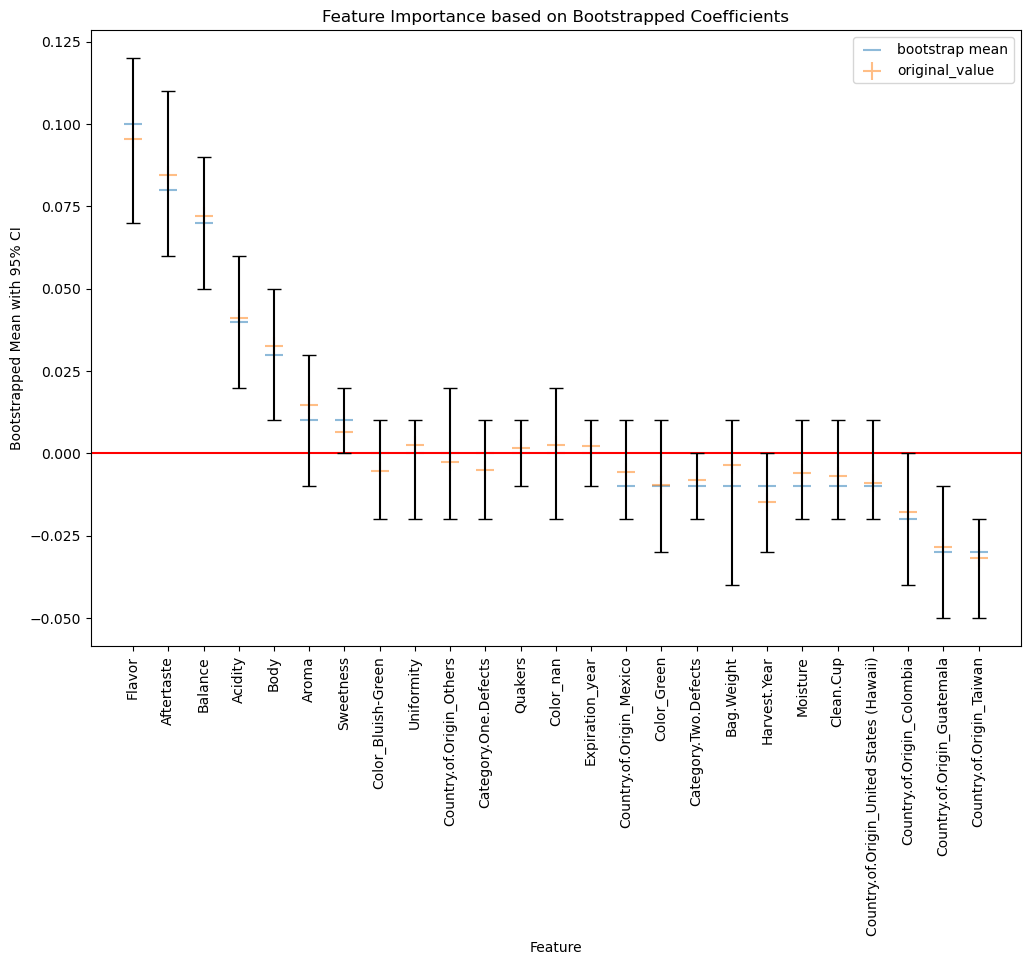

In [39]:
sorted_features = boot_beta_df.sort_values(by='boot_mean', ascending=False)
fig, ax = plt.subplots(figsize=(12, 8))

# Reset the index for proper alignment
sorted_features.reset_index(drop=True, inplace=True)
ax.axhline(y=0, color='r', linestyle='-')
ax.scatter(x="feature", y="boot_mean", data=sorted_features, label="bootstrap mean", marker="_", s=150, alpha = 0.5)
ax.scatter(x="feature", y="original_value", data=sorted_features, label="original_value", marker="+", s=150, alpha = 0.5)

# Add error bars for the 95% CI using the sorted order
ax.errorbar(x=sorted_features.index, y=sorted_features['boot_mean'], 
             yerr=[sorted_features['boot_mean'] - sorted_features['95_low'], sorted_features['95_high'] - sorted_features['boot_mean']], 
             fmt='none', color='black', capsize=5)
plt.xticks(rotation=90)

ax.set_xlabel('Feature')
ax.set_ylabel('Bootstrapped Mean with 95% CI')
ax.set_title('Feature Importance based on Bootstrapped Coefficients')
plt.legend()
plt.show()


The previous graph allows us to better understand the actual importance of each feature while predicting a coffee general grade.
By looking at it, we can see that only 10 features have an actually meaningful impact.

In further iterations of our work, we will try to use different subset of features (by incorporating categorical features not yet used) to better find the one linked to coffee quality. Linear regression has been chosen as it is an easy to interpret model in that case. We will also try to use decision tree algorithm to have another approach on feature importance.

## Final Model Pipeline: 


In [40]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns:list=None):
        self.columns = columns
        self.ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore")
        self.transformed_df = None

    def fit(self, X, y=None):
        if self.columns is None:
            self.ohe.fit(X)
        else:
            self.ohe.fit(X[self.columns])
        return self
    
    def transform(self, X):
        if self.columns is None:
            self.transformed_df = self.ohe.transform(X)
        else:
            self.transformed_df = self.ohe.transform(X[self.columns])
        self.merge(X)
        return self.transformed_df
    
    def merge(self, X):
        if self.columns is None:
            raise ValueError('Input columns to merge, please.')
            
        # Drop the original columns and merge with the transformed_df
        self.transformed_df = pd.merge(
            X.drop(columns=self.columns).reset_index(drop=True),
            pd.DataFrame(self.transformed_df, columns=self.ohe.get_feature_names_out()).reset_index(drop=True),
            left_index=True,
            right_index=True
        )
        return self.transformed_df 
        
    def fit_transform(self, X, y=None):
        self.fit(X)
        self.transform(X)
        return self.transformed_df

In [41]:
# Create pipeline
pipeline = Pipeline([
    ('custom_ohe', CustomOneHotEncoder(categorical_cols)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

In [42]:
# Test the new Pipeline
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(train, y, 
                                                    test_size = 0.2,
                                                    random_state=0, 
                                                    shuffle=True)


# Fit and transform the pipeline on the training data
X_train_transformed = pipeline.fit(X_train_2, y_train_2)

# Predict on the test set
y_pred_test_2 = pipeline.predict(X_test_2)
y_pred_train_2 = pipeline.predict(X_train_2)

# Evaluate the model
score_test = r2_score(y_test_2, y_pred_test_2)
score_train = r2_score(y_train_2, y_pred_train_2)
print('Linear regression train score:', score_train)
print('Linear regression test score:', score_test)

Linear regression train score: 0.7542781608142579
Linear regression test score: 0.765411202932507
